In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from pandas import ExcelFile
from geopy.geocoders import Nominatim
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import re
%matplotlib inline

initial_data = pd.read_csv('properties_2017.csv')
zillow_total_log = pd.read_csv('train_2016_v2.csv')
zillow_total_log_2 = pd.read_csv('train_2017.csv')
initial_data_2 = pd.concat([zillow_total_log,zillow_total_log_2], axis=0)
total_data = pd.merge(initial_data, initial_data_2, how = 'right', on = 'parcelid')

/Users/sahilsobti/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Filling the missing values 
features = ['bathroomcnt','finishedsquarefeet12','yearbuilt', 
            'structuretaxvaluedollarcnt','landtaxvaluedollarcnt', 'regionidcounty']
q1_data = total_data[features]
q1_data = q1_data.dropna(subset=['regionidcounty'],how='all')
grouped_col = q1_data.groupby("regionidcounty")
q1_data['yearbuilt'] = grouped_col.yearbuilt.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['bathroomcnt'] = grouped_col.bathroomcnt.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['finishedsquarefeet12'] = grouped_col.finishedsquarefeet12.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['structuretaxvaluedollarcnt'] = grouped_col.structuretaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
q1_data['landtaxvaluedollarcnt'] = grouped_col.landtaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
q1_data['yearbuilt'] = 2017 - q1_data['yearbuilt']
q1_data['finishedsquarefeet12'] = np.log(q1_data['finishedsquarefeet12'])
q1_data['structuretaxvaluedollarcnt'] = np.log(q1_data['structuretaxvaluedollarcnt'])
q1_data['landtaxvaluedollarcnt'] = np.log(q1_data['landtaxvaluedollarcnt'])

In [4]:
from sklearn import preprocessing
minn = 1
maxx = 10
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(minn, maxx))

bathroomcnt_x = q1_data.bathroomcnt.values.reshape(-1,1) #returns a numpy array
finishedsquarefeet12_x = q1_data.finishedsquarefeet12.values.reshape(-1,1) #returns a numpy array
structuretaxvaluedollarcnt_x = q1_data.structuretaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array
landtaxvaluedollarcnt_x = q1_data.landtaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array

bathroomcnt_x_scaled = min_max_scaler.fit_transform(bathroomcnt_x)
finishedsquarefeet12_x_scaled = min_max_scaler.fit_transform(finishedsquarefeet12_x)
structuretaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(structuretaxvaluedollarcnt_x)
landtaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(landtaxvaluedollarcnt_x)

q1_data.bathroomcnt = bathroomcnt_x_scaled
q1_data.finishedsquarefeet12 = finishedsquarefeet12_x_scaled
q1_data.structuretaxvaluedollarcnt = structuretaxvaluedollarcnt_x_scaled
q1_data.landtaxvaluedollarcnt = landtaxvaluedollarcnt_x_scaled

In [5]:
def normalizeyears(x):
    if x <= 7 and x >= 0:
        return 10
    elif x > 7 and x <= 17:
        return 7
    elif x > 17 and x <= 80:
        return 5
    elif x > 80 and x <= 90:
        return 8
    elif x > 90 and x <= 100:
        return 9
    elif x >100:
        return 10
def countynormalize(x):
    # fn = 200/(1+ 10*VC + PC)
    #Ventura = 2061
    #VC = 2.3 and PC = 20.1
    #LA = 3101
    #VC = 4.3 and PC = 21.8
    #Orange = 1286
    #VC = 2.0 and PC = 17.7
    if x == 2061:
        r = 4.535
    elif x == 3101:
        r = 3.03
    #Orange
    elif x == 1286:
        r = 5.16
    return r    

In [6]:
yearbuilt_series = q1_data.yearbuilt.apply(normalizeyears)
q1_data.yearbuilt = yearbuilt_series.to_frame(name= 'yearbuilt')

regionidcounty_series = q1_data.regionidcounty.apply(countynormalize)
q1_data.regionidcounty = regionidcounty_series.to_frame(name= 'regionidcounty')

In [7]:
def scoringfunction(row):
    denominator = np.log2(row.structuretaxvaluedollarcnt) * np.log2(row.landtaxvaluedollarcnt)
    result = (row.bathroomcnt * np.log2(row.finishedsquarefeet12) * row.regionidcounty * np.sqrt(row.yearbuilt) ) 
    / np.sqrt(denominator)
    return result

# Scoring Function######
Score = (bathroomcnt * log(finishedsquarefeet12) * regionidcounty * sqrt(yearbuilt) )/ log(structuretaxvaluedollarcnt) * log(landtaxvaluedollarcnt)

#### Description:
The scoring function is formulated with the idea that it should give the most desirable houses in the dataset. It is designed using the parameters which contribute to the overall diserability of the house. 
To start with, the scoring function is directly proportional to bathroomcnt , finishedsquarefeet, regionidcounty and yearbuilt. As the number of bathrooms at a particular house increases, the overall price/diserability of the house increases. The similar logic applies to the variable finishedsquarefeet.
While taking the regionidcounty, we preferred to extract the external data of the crime rate in each of the county to provide value to this feature vector.
So, the formula used for calculating the diserability is based on crime rate in each county is shown below:
 
 ### fn = 200/(1+ 10*VC + PC)
Here, for Ventura (2061) , VC = 2.3 and PC = 20.1
      for LA (3101), VC = 4.3 and PC = 21.8
      for Orange = 1286, VC = 2.0 and PC = 17.7
VC is defined as Violent Crime and PC is defined as property Crime.
Since VC is looked upon more while purchasing the house, we have given ten times higher weightage to VC compared to PC.
Additionally, as you can see , As the crime rate increases, the overall diserability decreases.
This assumption is based on the idea that, people tend to buy less houses where the crime rate is high.
Another feature vector in the numerator is the yearbuilt. Yearbuilt is initially subtracted from 2017 and then normalized in the range of 0-10 based on few assumptions.
Assumptions for yearbuilt:
1. If the house is too old or new i.e > 100 years or  < 7 years, then it ought to have a high price.
2. Whereas if the house doesnt belong to the aforementioned years then the year built will not affect the price much and therefore, the value assigned will be low.

Coming to the denominator, the score is inversely proportional to the structuretaxvaluedollarcnt and landtaxvaluedollarcnt.

All the features are normalized in the range of 0-10 in order to make them comparable.
##### Ref: 
https://www.cde.ca.gov/ds/si/ds/
https://en.wikipedia.org/wiki/California_locations_by_crime_rate

### TOP TEN DISERABLE HOUSES ARE AS FOLLOWS:

In [8]:
#Question - 1
q1_data['score'] = q1_data.apply(scoringfunction, axis = 1)
sorted_by_score = q1_data.sort_values(by = 'score', ascending=False)
sorted_by_score.head(10)

,bathroomcnt,finishedsquarefeet12,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,regionidcounty,score
31006,5.725,9.236522,10,9.191004,8.299586,5.16,299.620487
99083,9.100,9.843509,8,6.507387,10.000000,3.03,257.296610
60006,4.825,8.952119,10,8.826954,8.307965,5.16,248.966185
45708,5.500,9.319230,7,9.158618,7.967995,5.16,241.794109
96258,4.600,9.205031,10,8.755157,8.847053,5.16,240.373272
17380,4.375,9.108455,10,8.499044,6.043696,5.16,227.529618
73413,5.050,9.612974,7,9.303784,8.027070,5.16,225.097675
44142,5.050,9.598718,7,9.144249,8.073567,5.16,224.950062
99424,5.050,9.525837,7,8.457747,6.565948,5.16,224.191972
141439,4.150,9.231458,10,8.582294,7.192656,5.16,217.138568


### TOP TEN LEAST DISERABLE HOUSES ARE AS FOLLOWS:

In [9]:
sorted_by_score = q1_data.sort_values(by = 'score', ascending=True)
sorted_by_score.head(10)

,bathroomcnt,finishedsquarefeet12,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,regionidcounty,score
151348,2.35,1.000000,5,6.866103,5.927086,3.03,0.000000
60288,1.00,4.961239,5,1.670877,3.891448,3.03,15.655656
166059,1.00,3.898342,7,1.612924,2.268388,3.03,15.735521
145407,1.00,5.023679,5,1.996657,5.086132,3.03,15.777909
108227,1.00,5.455458,5,1.810601,4.624351,3.03,16.583869
47878,1.00,5.780992,5,4.760188,7.192998,3.03,17.150396
73953,1.00,5.847741,5,5.480154,6.872953,3.03,17.262612
37757,1.00,6.040128,5,1.757988,5.242946,3.03,17.579015
97502,1.00,6.099092,5,5.747802,6.324658,3.03,17.673974
86385,1.00,6.126071,5,4.231664,3.980903,3.03,17.717116


In [72]:
### Question -2 
distance_columns = ['latitude', 'longitude', 'bathroomcnt', 'regionidcounty', 'regionidzip', 'propertylandusetypeid']
q2_data = total_data[distance_columns]
q2_data = q2_data.dropna(how='all')
q2_data['regionidzip'] = q2_data['regionidzip'].fillna(q2_data['regionidzip'].mode()[0])
q2_data.head()

,latitude,longitude,bathroomcnt,regionidcounty,regionidzip,propertylandusetypeid
0,34449407.0,-119254052.0,5.0,2061.0,97099.0,261.0
1,34454169.0,-119237898.0,2.0,2061.0,97099.0,261.0
2,34365693.0,-119448392.0,1.5,2061.0,97081.0,261.0
3,34303597.0,-119287236.0,2.5,2061.0,97081.0,265.0
4,34305600.0,-119284000.0,2.0,2061.0,97081.0,266.0


In [73]:
def distance_function(propdata1, propdata2):
    return euclidean_distances(propdata1, propdata2)

In [74]:
sampled_data = q2_data.sample(100, random_state=0, axis=0)
distance_matrix = np.zeros((len(sampled_data.index), len(sampled_data.index)))
for i in range(len(sampled_data.index)):
    for j in range(len(sampled_data.index)):
        distance_matrix[i][j] = distance_function(sampled_data[i:i+1], sampled_data[j:j+1])

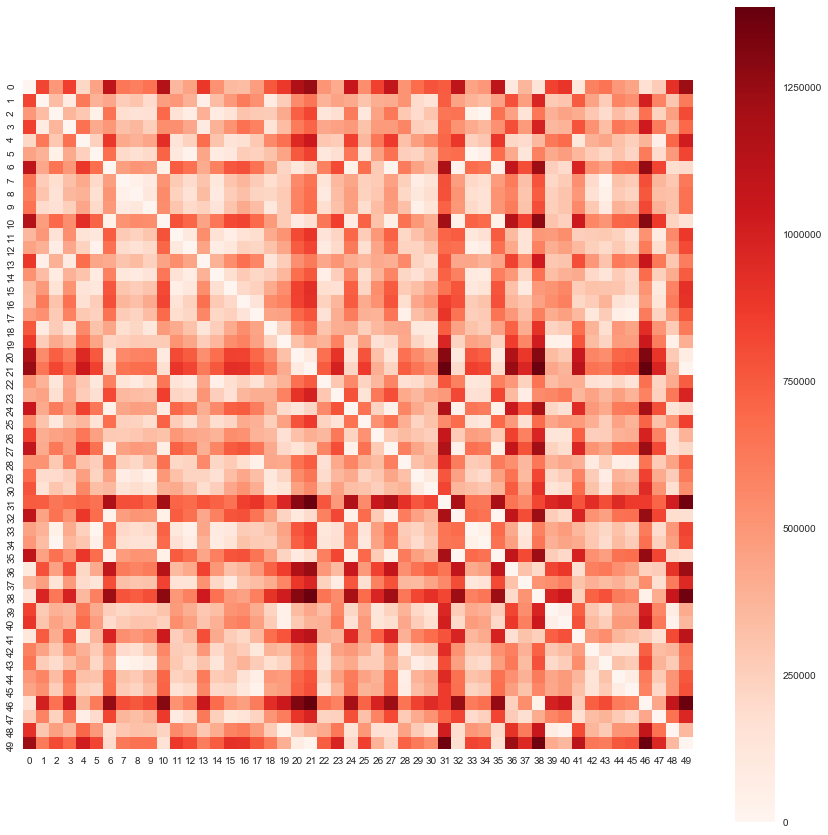

In [75]:
display_matrix = distance_matrix[0:50,0:50]
plt.figure(figsize=(15,15))
sb.heatmap(display_matrix, square=True, cmap='Reds')
plt.show()

In [17]:
####Question -3 #############
reduced_data = PCA(n_components=2).fit_transform(q2_data)
kmeans = KMeans(n_clusters=10, random_state=0).fit(reduced_data)
labels = kmeans.predict(reduced_data)
q2_data.loc[:, 'label'] = labels
centroids = kmeans.cluster_centers_

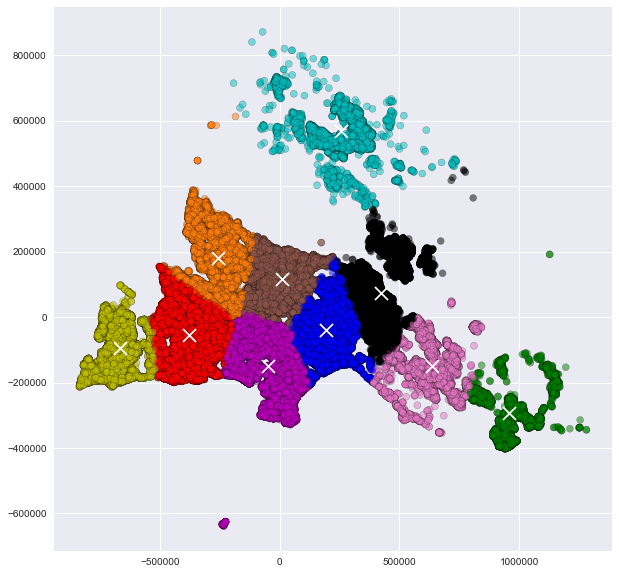

In [18]:
fig = plt.figure(figsize=(10, 10))
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'c', 5: 'm', 6: 'y',7:'k',8:'tab:orange',9:'tab:brown',10:'tab:pink'}

# colors = map(lambda x: colmap[x+1], labels)
colors = [colmap[x+1] for x in labels]
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, c='w', marker='x',zorder=10, s=170)
plt.show()

In [ ]:
#Question 4

q4_data = total_data.copy()
q4_data = q4_data.reindex(columns = np.append(q4_data.columns.values, ['Geopy_Zip']))

#evaluate zip codes from geopy
df_zip = q4_data[['latitude', 'longitude','regionidzip','Geopy_Zip']]
df_zip = df_zip.drop_duplicates('regionidzip')

# #Finding Zips
geolocator = Nominatim()
def findDefault(address):
    county = address['county']
    if(county == "Los Angeles County"):
        zip = [11111]
        return zip
    elif(county == "Orange County"):
        zip = [22222]
        return zip
    elif(county == "Ventura County"):
        zip = [33333]
        return zip

def findZip(latlong):
    location = geolocator.reverse(latlong)
    zipID = 0
    if("postcode" in location.raw['address']):
        zipID = [int(s) for s in re.findall(r'\b\d+\b', location.raw['address']['postcode'])]
    else:
        zipID = findDefault(location.raw['address'])
        if(len(zipID) == 0):
            zipID = findDefault(location.raw['address'])
    return zipID[0]

for index, row in df_zip.iterrows():
    lat = ((row['latitude'])/1000000)
    lat = str(lat)
    long = ((row['longitude'])/1000000)
    long = str(long)
    val = lat + ',' + long
    zipID = findZip(val)
    row['Geopy_Zip'] = zipID

In [29]:
#Populating q3_data
q4_data.Geopy_Zip = q4_data.Geopy_Zip.astype(float)

for index, row in q4_data.iterrows():
    if(np.isnan(row['regionidzip']) == False):
        zipid = row['regionidzip']
        val = df_zip.loc[df_zip['regionidzip'] == zipid, 'Geopy_Zip'].iloc[0]
        q4_data.loc[index, 'Geopy_Zip'] = val
    else:
        lat = ((row['latitude'])/1000000)
        lat = str(lat)
        long = ((row['longitude'])/1000000)
        long = str(long)
        val = lat + ',' + long
        zipID = findZip(val)
        q4_data.loc[index, 'Geopy_Zip'] = zipID

q4_data.loc[q4_data['Geopy_Zip'] == 11111,'Geopy_Zip'] = np.nan
q4_data.loc[q4_data['Geopy_Zip'] == 22222,'Geopy_Zip'] = np.nan
q4_data.loc[q4_data['Geopy_Zip'] == 33333,'Geopy_Zip'] = np.nan

#Populating empty ZIP's with mode
q4_data_part = q4_data[['regionidcounty', 'Geopy_Zip']]
grouped_col = q4_data_part.groupby("regionidcounty")
q4_data['Geopy_Zip'] = grouped_col.Geopy_Zip.transform(lambda x: x.fillna(x.mode()[0]))

#Adding new column School Count
q4_data = q4_data.reindex(columns = np.append(q4_data.columns.values, ['School_Count']))

#Reading excel file for Schools with Zip Code
school_df = pd.read_excel('school_list_filtered.xls')
school_df_filtered = school_df[school_df.County.str.startswith(('Los Angeles', 'Orange', 'Ventura'))]
#remove Nan values for Zip
school_df_filtered = school_df_filtered[school_df_filtered.Zip.notnull()]
df_school = (school_df_filtered.Zip.value_counts()).to_frame().reset_index()
df_school.columns = ['regionidzip', 'zipcount']

#Integrating the data of School Count with Zip Code
#total_data.School_Count = total_data.School_Count.astype(int)
for index, row in q4_data.iterrows():
    if(np.isnan(row['School_Count']) == True):
        zipid = row['Geopy_Zip']
        if((len(df_school.loc[df_school['regionidzip'] == zipid, 'zipcount']) > 0)):
            val = df_school.loc[df_school['regionidzip'] == zipid, 'zipcount'].iloc[0]
            q4_data.loc[index, 'School_Count'] = val

#Writing CSV file
q4_data.to_csv('total_data_with_school_count.csv')

In [92]:
#creating HashMap
q4_hash_data = pd.read_csv('total_data_with_school_count.csv')

#Create a Dictionary

df_temp = q4_hash_data[['Geopy_Zip', 'School_Count']]

ZiptoSchool = {}
for index, row in df_temp.iterrows():
    zipID =  row['Geopy_Zip']
    SchoolData = row['School_Count']
    ZiptoSchool[zipID] = SchoolData

df_temp = q4_hash_data[['regionidzip', 'Geopy_Zip']]

KZiptoActualZip = {}
for index, row in df_temp.iterrows():
    KZip = row['regionidzip']
    zipID = row['Geopy_Zip']
    if(np.isnan(KZip) == False):
        KZiptoActualZip[KZip] = zipID

In [78]:
import json
with open('ZiptoSchool.json', 'w') as fp:
    json.dump(ZiptoSchool, fp)
with open('KZiptoActualZip.json', 'w') as fp:
    json.dump(KZiptoActualZip, fp)

In [93]:
import json
with open('ZiptoSchool.json', 'r') as fp:
    SchoolZip = json.load(fp)
with open('KZiptoActualZip.json', 'r') as fp:
    KToActualZip = json.load(fp)
print (SchoolZip)    

{'93023.0': 15.0, '93001.0': 13.0, '93006.0': nan, '93004.0': 4.0, '93060.0': 21.0, '93010.0': 24.0, '93012.0': 12.0, '93035.0': 4.0, '93031.0': nan, '93033.0': 21.0, '93065.0': 29.0, '93021.0': 19.0, '91360.0': 22.0, '91362.0': 10.0, '93063.0': 13.0, '91320.0': 11.0, '91301.0': 11.0, '91302.0': 16.0, '91361.0': 10.0, '91325.0': 12.0, '91328.0': nan, '91311.0': 13.0, '91406.0': 15.0, '91356.0': 6.0, '91343.0': 20.0, '91401.0': 9.0, '91403.0': 2.0, '91605.0': 10.0, '91601.0': 9.0, '91604.0': 1.0, '91504.0': 8.0, '91342.0': 31.0, '91340.0': 21.0, '91352.0': 20.0, '91042.0': 6.0, '91344.0': 20.0, '91324.0': 9.0, '91351.0': 15.0, '91354.0': 5.0, '91381.0': 5.0, '91321.0': 13.0, '91387.0': 4.0, '91327.0': nan, '91384.0': 6.0, '93551.0': 16.0, '93550.0': 31.0, '93552.0': 10.0, '93543.0': 12.0, '93553.0': 2.0, '93536.0': 26.0, '93534.0': 23.0, '93510.0': 15.0, '90302.0': 8.0, '90301.0': 20.0, '90305.0': 7.0, '90037.0': 23.0, '90249.0': 5.0, '90045.0': 24.0, '90293.0': 1.0, '90245.0': 15.0, '9

In [94]:
def findZiptoSchoolCount(zipID):
    if zipID == -1:
        return -1
    zipID = str(zipID)
    if(zipID in SchoolZip):
        return SchoolZip[zipID]
    else:
        return -1

def findActualZipfromKZip(zipID):
    zipID = str(zipID)
    if(zipID in KToActualZip):
        return KToActualZip[zipID]
    else:
        return -1

def addSchoolCountToData(tdata):
    apnadata = tdata.copy()
    apnadata = apnadata.reindex(columns = np.append(apnadata.columns.values, ['schoolcount']))
    for index, row in apnadata.iterrows():
        if(np.isnan(row['regionidzip']) == False):
            zipid = findActualZipfromKZip(row['regionidzip'])
            school_cnt = findZiptoSchoolCount(zipid)
            apnadata.loc[index, 'schoolcount'] = school_cnt
    return apnadata

In [95]:
q4_data = addSchoolCountToData(total_data)
q4_data.schoolcount.head()

0    15.0
1    15.0
2    13.0
3    13.0
4    13.0
Name: schoolcount, dtype: float64

In [135]:
############### Question - 5 ########################
from sklearn import preprocessing
def fillMissingdata(df,cols):
    dff = df.copy()
    model_data = dff[cols]
    model_data['regionidcounty'].fillna(model_data['regionidcounty'].mode()[0], inplace=True)
    grouped_col = model_data.groupby("regionidcounty")
    model_data['yearbuilt'] = grouped_col.yearbuilt.transform(lambda x: x.fillna(x.mode()[0]))
    model_data['bathroomcnt'] = grouped_col.bathroomcnt.transform(lambda x: x.fillna(x.mode()[0]))
    model_data['finishedsquarefeet12'] = grouped_col.finishedsquarefeet12.transform(lambda x: x.fillna(x.mode()[0]))
    model_data['structuretaxvaluedollarcnt'] = grouped_col.structuretaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
    model_data['landtaxvaluedollarcnt'] = grouped_col.landtaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
    model_data['yearbuilt'] = 2017 - model_data['yearbuilt']
    model_data['finishedsquarefeet12'] = np.log(model_data['finishedsquarefeet12'])
    model_data['structuretaxvaluedollarcnt'] = np.log(model_data['structuretaxvaluedollarcnt'])
    model_data['landtaxvaluedollarcnt'] = np.log(model_data['landtaxvaluedollarcnt'])
    del(model_data['regionidcounty'])
    return model_data

def scalingData(somedata, cols):
    q1_data = somedata.copy()
    minn = 1
    maxx = 10
    min_max_scaler = preprocessing.MinMaxScaler(feature_range =(minn, maxx))

    bathroomcnt_x = q1_data.bathroomcnt.values.reshape(-1,1) #returns a numpy array
    finishedsquarefeet12_x = q1_data.finishedsquarefeet12.values.reshape(-1,1) #returns a numpy array
    structuretaxvaluedollarcnt_x = q1_data.structuretaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array
    landtaxvaluedollarcnt_x = q1_data.landtaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array

    bathroomcnt_x_scaled = min_max_scaler.fit_transform(bathroomcnt_x)
    finishedsquarefeet12_x_scaled = min_max_scaler.fit_transform(finishedsquarefeet12_x)
    structuretaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(structuretaxvaluedollarcnt_x)
    landtaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(landtaxvaluedollarcnt_x)

    q1_data.bathroomcnt = bathroomcnt_x_scaled
    q1_data.finishedsquarefeet12 = finishedsquarefeet12_x_scaled
    q1_data.structuretaxvaluedollarcnt = structuretaxvaluedollarcnt_x_scaled
    q1_data.landtaxvaluedollarcnt = landtaxvaluedollarcnt_x_scaled

    yearbuilt_series = q1_data.yearbuilt.apply(normalizeyears)
    q1_data.yearbuilt = yearbuilt_series.to_frame(name= 'yearbuilt')
    
    return q1_data

In [136]:
cols =  ['bathroomcnt','finishedsquarefeet12','yearbuilt', 
             'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'regionidcounty','logerror','parcelid']

q5_data = fillMissingdata(total_data,cols)
q5_data = scalingData(q5_data, cols)
q5_data.head()

/Users/sahilsobti/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sahilsobti/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sahilsobti/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

,bathroomcnt,finishedsquarefeet12,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,logerror,parcelid
0,3.250,8.293936,5,6.519315,7.583290,-0.013099,17054981
1,1.900,7.368046,5,6.380549,6.635866,0.073985,17055743
2,1.675,7.524812,5,5.534609,6.911271,0.071886,17068109
3,2.125,7.239238,5,5.406764,6.556094,0.095300,17073783
4,1.900,6.998933,5,5.956949,6.374955,0.305680,17073952


In [146]:
x = q5_data.drop(['logerror', 'parcelid'], axis=1, inplace=False)
y = q5_data.logerror.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((117521, 5), (117521,), (50367, 5), (50367,))

In [138]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


lgb_model = LGBMRegressor(n_estimators = 400,
max_bin = 8,
learning_rate = 0.037,
num_leaves = 20,
min_data = 10,         
min_hessian = 0.05,
verbose = 0,
feature_fraction_seed = 2,
bagging_seed = 3)

lgb_model.fit(x_train, y_train)
lgb_prediction = lgb_model.predict(x_test)


lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)
prediction = lr.predict(x_test)

grad_model = GradientBoostingRegressor(n_estimators=100, 
     learning_rate=0.1,
     max_depth=2,  
     loss='ls',
     criterion = 'mse')

grad_model.fit(x_train, y_train)
grad_prediction = grad_model.predict(x_test)

In [139]:
###LGB Predictor
print("KNN Mean squared error: %.5f"
      % mean_squared_error(y_test, lgb_prediction))
print('KNN Variance score: %.5f' % r2_score(y_test, lgb_prediction))

###Linear Predictor
print("KNN Mean squared error: %.5f"
      % mean_squared_error(y_test, prediction))
print('KNN Variance score: %.5f' % r2_score(y_test, prediction))

###GradientBoostingRegressor Predictor
print("KNN Mean squared error: %.5f"
      % mean_squared_error(y_test, grad_prediction))
print('KNN Variance score: %.5f' % r2_score(y_test, grad_prediction))

KNN Mean squared error: 0.02755
KNN Variance score: 0.00516
KNN Mean squared error: 0.02757
KNN Variance score: 0.00434
KNN Mean squared error: 0.02754
KNN Variance score: 0.00562


In [140]:
##############Question 5 Submission data ###########
samplesub = pd.read_csv('sample_submission.csv')
cols =  ['bathroomcnt','finishedsquarefeet12','yearbuilt', 
             'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'regionidcounty','parcelid']
q5_data_b = fillMissingdata(initial_data,cols)
q5_data_b = scalingData(q5_data_b, cols)
q5_data_b.head()

/Users/sahilsobti/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sahilsobti/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sahilsobti/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

,bathroomcnt,finishedsquarefeet12,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,parcelid
0,1.0,6.048436,5,2.077134,6.620401,10754147
1,1.0,6.048436,5,6.011335,6.620401,10759547
2,1.0,6.048436,5,7.647284,7.230448,10843547
3,1.0,6.048436,5,7.517703,7.169943,10859147
4,1.0,6.048436,5,7.079894,6.667273,10879947


In [147]:
import datetime
sample = samplesub.copy()
sample["parcelid"] = sample["ParcelId"]
del (sample['ParcelId'])
x_sample = pd.merge(sample, q5_data_b, on="parcelid", how="left")
x_sample = x_sample.drop(['parcelid','201610', 
              '201611','201612','201710','201711','201712'], axis=1)
x_sample.head()

,bathroomcnt,finishedsquarefeet12,yearbuilt,landtaxvaluedollarcnt,structuretaxvaluedollarcnt
0,1.0,6.048436,5,2.077134,6.620401
1,1.0,6.048436,5,6.011335,6.620401
2,1.0,6.048436,5,7.647284,7.230448
3,1.0,6.048436,5,7.517703,7.169943
4,1.0,6.048436,5,7.079894,6.667273


In [153]:
y_sample = pd.DataFrame(lgb_model.predict(x_sample)) # predicting for grad , can replace this for each model
y_sample["201611"] = y_sample[0]
y_sample["201612"] = y_sample[0]
y_sample["201710"] = y_sample[0]
y_sample["201711"] = y_sample[0]
y_sample["201712"] = y_sample[0]
y_sample.columns = ["201610","201611","201612","201710","201711","201712"]                    
submit = y_sample.copy()
submit["ParcelId"] = samplesub["ParcelId"]
columns = ["ParcelId","201610","201611","201612","201710","201711","201712"]
submit = submit[columns]
filename = "Prediction_lgb" + str(datetime.datetime.now()) + '.csv' # suffix _grad to identify the model that is being used
print(filename)
submit.to_csv(filename,index=False)

Prediction_lgb2017-10-15 23:27:24.687281.csv


Index(['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712'], dtype='object')

In [159]:
submit.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.028629,-0.028629,-0.028629,-0.028629,-0.028629,-0.028629
1,10759547,0.002763,0.002763,0.002763,0.002763,0.002763,0.002763
2,10843547,-0.054008,-0.054008,-0.054008,-0.054008,-0.054008,-0.054008
3,10859147,-0.017167,-0.017167,-0.017167,-0.017167,-0.017167,-0.017167
4,10879947,0.009308,0.009308,0.009308,0.009308,0.009308,0.009308
